In [1]:
!pip install gensim

In [2]:
!pip install datasets

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datasets import load_dataset

In [4]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Load dataset from Hugging Face
dataset = load_dataset("sms_spam")
df = dataset['train'].to_pandas()
df.rename(columns={"label": "category", "sms": "message"}, inplace=True)
df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,message,category
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


In [6]:
# Balance the dataset (if spam is underrepresented)
spam_samples = df[df['category'] == 1]
ham_samples = df[df['category'] == 0].sample(len(spam_samples))  # Equal ham & spam
df_balanced = pd.concat([spam_samples, ham_samples])

In [7]:
# Data Cleaning
def clean_text(text):
    text = text.lower()
    # text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stopwords.words('english')]
    return text

df_balanced['cleaned_message'] = df_balanced['message'].apply(clean_text)

In [8]:
# Creating Corpus
corpus = df_balanced['cleaned_message'].tolist()

In [9]:
# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)
# Function to Convert Text to Word2Vec Feature Vector
def get_avg_vector(words, model, vector_size):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)  # Return zero vector if no words match
    return np.mean(vectors, axis=0)  # Take average of word vectors

df_balanced['vector'] = df_balanced['cleaned_message'].apply(lambda x: get_avg_vector(x, word2vec_model, 100))

In [10]:
# Extract word vectors
word_vectors = word2vec_model.wv
words = list(word_vectors.index_to_key)
wv=word_vectors.vectors
wv

array([[-0.0339899 ,  0.05160764,  0.03033769, ..., -0.07986152,
         0.02055417,  0.01173166],
       [-0.03591414,  0.04710183,  0.02766329, ..., -0.0608956 ,
         0.00847136,  0.00661369],
       [-0.02600573,  0.04290828,  0.01284246, ..., -0.05451941,
         0.02461971, -0.00508059],
       ...,
       [ 0.00565415,  0.005388  , -0.00409811, ...,  0.00075618,
        -0.00970052, -0.00059859],
       [ 0.00468006,  0.00910215, -0.00788237, ...,  0.00529899,
        -0.00100943, -0.00332815],
       [-0.00281359, -0.00505406, -0.00582343, ...,  0.00609009,
         0.00987503, -0.00151836]], dtype=float32)

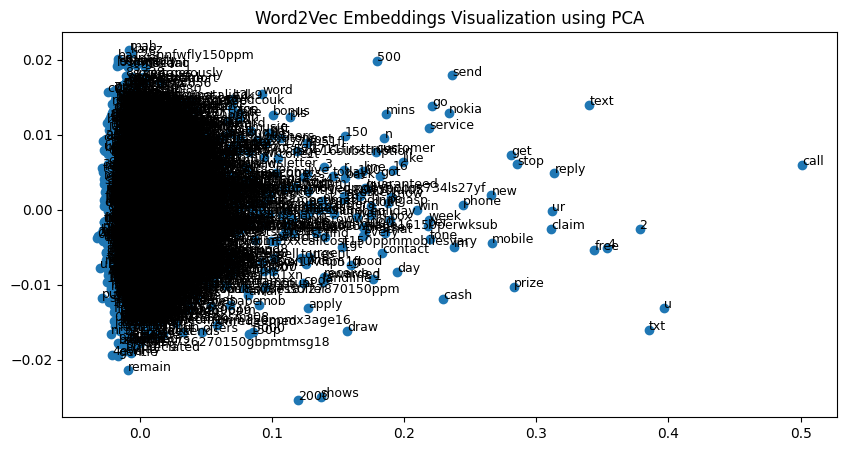

In [11]:
# Visualizing Embeddings using PCA
pca = PCA(n_components=2)
word_vecs_pca = pca.fit_transform(word_vectors[words])
plt.figure(figsize=(10, 5))
plt.scatter(word_vecs_pca[:, 0], word_vecs_pca[:, 1], marker='o')
for word, (x, y) in zip(words, word_vecs_pca):
    plt.text(x, y, word, fontsize=9)
plt.title("Word2Vec Embeddings Visualization using PCA")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


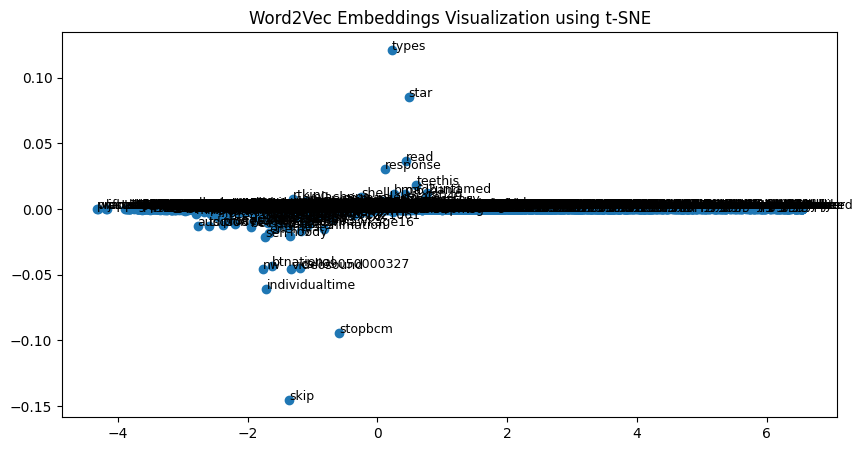

In [12]:
# Visualizing with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
word_vecs_tsne = tsne.fit_transform(word_vectors[words])
plt.figure(figsize=(10, 5))
plt.scatter(word_vecs_tsne[:, 0], word_vecs_tsne[:, 1], marker='o')
for word, (x, y) in zip(words, word_vecs_tsne):
    plt.text(x, y, word, fontsize=9)
plt.title("Word2Vec Embeddings Visualization using t-SNE")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare Data for Classification
X = np.vstack(df_balanced['vector'])
y = df_balanced['category']  # No need to encode, already 0 (ham) and 1 (spam)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression Classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict and Evaluate
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Spam Classification Model Accuracy: {accuracy:.2f}")

# Function to Predict Spam or Ham
def predict_spam(text):
    cleaned_text = clean_text(text)
    vector = get_avg_vector(cleaned_text, word2vec_model, 100).reshape(1, -1)
    prediction = classifier.predict(vector)[0]
    return "Spam" if prediction == 1 else "Ham"


Spam Classification Model Accuracy: 0.78


In [14]:
# Test Example
sample_text = "Congratulations! You won a free entry to the worldcup. Click here to claim."
print(f"Prediction for test email: {predict_spam(sample_text)}")

Prediction for test email: Spam


In [15]:
sample_text = "Hey, let's catch up for coffee tomorrow."
print(f"Prediction for test email: {predict_spam(sample_text)}")

Prediction for test email: Ham
